<a href="https://colab.research.google.com/github/mayrtn/challengeAluraTelecom2/blob/main/challengeAluraTelecom2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación de Datos

In [1]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset limpio del Challenge 1
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
df = pd.read_json(url)

# Aplanar columnas tipo dict
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

df_flat = pd.concat([df.drop(columns=['customer','phone','internet','account']),
                     df_customer, df_phone, df_internet, df_account], axis=1)

# Limpiar columna Churn
df_flat = df_flat[df_flat['Churn'].isin(['Yes','No'])]

# Convertir sí/no a 1/0
bool_cols = ['Partner','Dependents','PaperlessBilling','PhoneService','MultipleLines',
             'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
             'StreamingTV','StreamingMovies']

for col in bool_cols:
    if col in df_flat.columns:
        df_flat[col] = df_flat[col].map({'Yes':1, 'No':0})

df_flat['Churn'] = df_flat['Churn'].map({'Yes':1,'No':0})

# Renombrar y convertir facturación a numérico
df_flat.rename(columns={'Charges.Monthly':'MonthlyCharges','Charges.Total':'TotalCharges'}, inplace=True)
df_flat['MonthlyCharges'] = pd.to_numeric(df_flat['MonthlyCharges'], errors='coerce')
df_flat['TotalCharges'] = pd.to_numeric(df_flat['TotalCharges'], errors='coerce')

# Eliminar duplicados
df_flat = df_flat.drop_duplicates()

# Verificar nulos
df_flat.isnull().sum()

,0
customerID,0
Churn,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,682
InternetService,0


#Selección de Features y Preparación para Modelos

In [2]:
# Eliminar columnas irrelevantes
X = df_flat.drop(columns=['Churn','customerID'])
y = df_flat['Churn']

# One-hot encode de variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Ver proporción de clases
print("Proporción de Churn:\n", y.value_counts(normalize=True))

Proporción de Churn:
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


#División Train/Test y Escalado

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado de variables numéricas
scaler = StandardScaler()
num_cols = ['tenure','MonthlyCharges','TotalCharges']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


#Modelado Predictivo

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer

# --- Imputación de valores faltantes ---

# Para columnas numéricas: rellenar con la media
num_cols = ['tenure','MonthlyCharges','TotalCharges']
imputer_num = SimpleImputer(strategy='mean')
X_train[num_cols] = imputer_num.fit_transform(X_train[num_cols])
X_test[num_cols] = imputer_num.transform(X_test[num_cols])

# Para columnas categóricas (one-hot codificadas): rellenar con la moda
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

# Verificar que no haya más NaN
print("Valores faltantes en X_train:\n", X_train.isnull().sum().sum())
print("Valores faltantes en X_test:\n", X_test.isnull().sum().sum())

# --- Entrenamiento de modelos ---

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


Valores faltantes en X_train:
 0
Valores faltantes en X_test:
 0


#Evaluación de Modelos

In [6]:
def evaluar_modelo(y_test, y_pred, modelo_name):
    print(f"--- {modelo_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))

evaluar_modelo(y_test, y_pred_lr, "Logistic Regression")
evaluar_modelo(y_test, y_pred_rf, "Random Forest")


--- Logistic Regression ---
Accuracy: 0.7934705464868701
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Confusion Matrix:
 [[923 112]
 [179 195]]
ROC-AUC: 0.7065889069725387
--- Random Forest ---
Accuracy: 0.7814052519517388
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.62      0.46      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

Confusion Matrix:
 [[929 106]
 [202 172]]
ROC-AUC: 0.6787387945955721


#Importancia de Variables

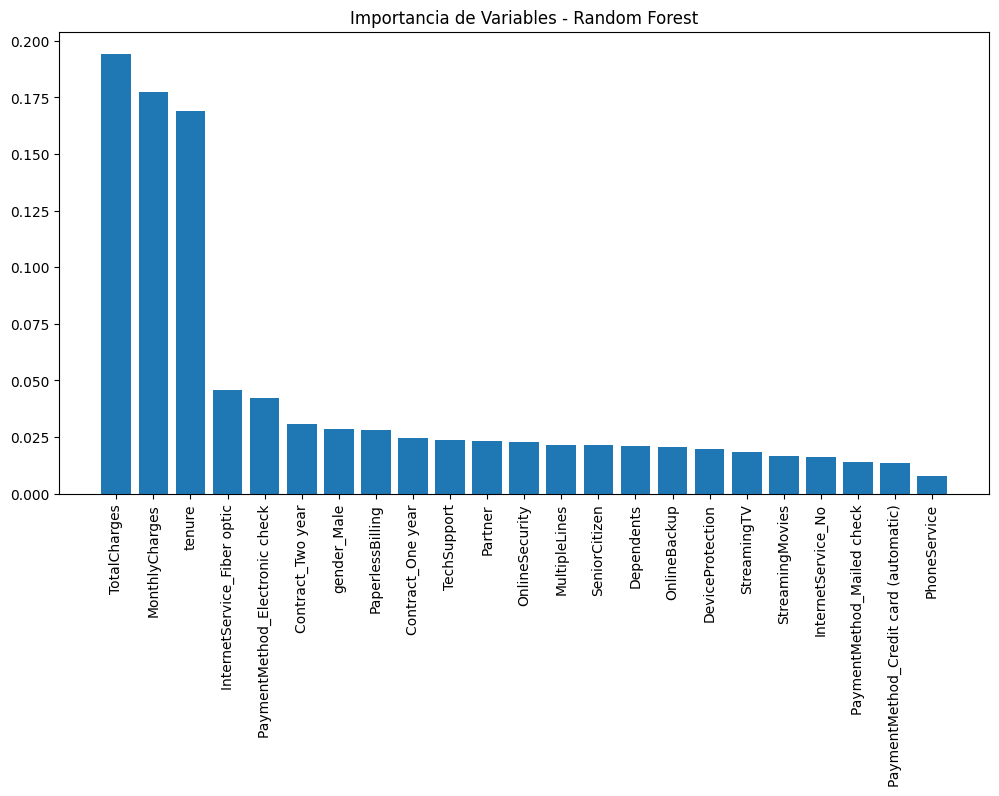

In [7]:
# Importancia de Random Forest
importances = rf.feature_importances_
features = X_train.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(12,6))
plt.title("Importancia de Variables - Random Forest")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.show()


#Conclusiones y Recomendaciones

# Conclusiones y Recomendaciones – Challenge 2

## Perfil de clientes con mayor riesgo
- Contratos mes a mes
- Menor antigüedad (tenure)
- Sin servicios adicionales (OnlineSecurity, TechSupport)
- Facturación mensual elevada pero reciente

## Variables más influyentes
- tenure
- Contract
- OnlineSecurity
- TechSupport
- MonthlyCharges

## Recomendaciones estratégicas
- Incentivar contratos más largos para clientes nuevos.
- Promover servicios adicionales para reducir Churn.
- Campañas personalizadas para clientes con mayor riesgo.
- Monitorear indicadores clave para ajustar estrategias de retención.
